# LEITURA DO BANCO E TRATAMENTO DOS DADOS

### Bibliotecas utilizadas em todo o projeto

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import chi2_contingency

### Definindo a paleta de cores

In [3]:
AZUL1, AZUL2, AZUL3, AZUL4, AZUL5, AZUL6 = '#174A7E', '#4A81BF', "#6495ED", '#2596BE', '#94AFC5', '#CDDBF3'
CINZA1, CINZA2, CINZA3, CINZA4, CINZA5, BRANCO = '#231F20', '#414040', '#555655', '#A6A6A5', '#BFBEBE', '#FFFFFF'
VERMELHO1, VERMELHO2, LARANJA1 = '#C3514E',	'#E6BAB7',	'#F79747'
VERDE1, VERDE2, VERDE3 = '#0C8040',	'#9ABB59', '#9ECCB3'

### Leitura das bases de dados e unificação em um único dataframe

In [4]:
df_depressao = pd.read_csv('DEMO_PHQ.csv')
df_atividade = pd.read_csv('PAG_HEI.csv')

df_completo = df_depressao.merge(df_atividade, on ='SEQN', how='left')

### Tratamento das Variáveis

In [5]:
replace_map = {
    'DPQ010': {7: np.nan, 9: np.nan},
    'DPQ020': {7: np.nan, 9: np.nan},
    'DPQ030': {7: np.nan, 9: np.nan},
    'DPQ040': {7: np.nan, 9: np.nan},
    'DPQ050': {7: np.nan, 9: np.nan},
    'DPQ060': {7: np.nan, 9: np.nan},
    'DPQ070': {7: np.nan, 9: np.nan},
    'DPQ080': {7: np.nan, 9: np.nan},
    'DPQ090': {7: np.nan, 9: np.nan},
    'RIDRETH1': {5: 2},
    'INDFMINC': {1:np.mean ([0,4999]),
                 2: np. mean ([5000,9999]),
                 3: np.mean([10000,14999]),
                 4: np.mean([15000,19999]) ,
                 5: np.mean([20000,24999]), 
                 6: np.mean([25000,34999]),
                 7: np.mean ( [35000,44999]), 
                 8: np. mean ( [45000,54999]) , 
                 9: np.mean ([55000, 64999]), 
                 10: np. mean ([ 65000,74999]) ,
                 11:75000, 
                 12: np.mean ([20000, 90000]), 
                 13: np.mean ([0, 19999]), 
                 77: np.nan, 
                 99: np.nan},
    }


df_completo = df_completo.replace(replace_map)

### Somando as respostas dos entrevistados em relação aos sintomas de depressão (**DPQ010** a **DPQ090**)
A variável **PHQ9** passa a ser a consolidação de todos os sintomas depressivos de cada participante, portanto, passarei a trabalhar com ela daqui em diante. \
Em seguida mostro como a nova variável se distribui.

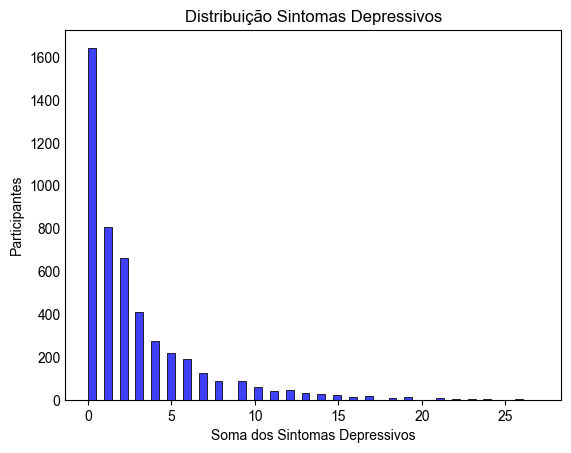

In [6]:
df_completo['PHQ9'] = df_completo[['DPQ010',
                                   'DPQ020',
                                   'DPQ030',
                                   'DPQ040',
                                   'DPQ050',
                                   'DPQ060',
                                   'DPQ070',
                                   'DPQ080',
                                   'DPQ090']].sum(axis='columns', skipna = False)

sns.histplot(data = df_completo['PHQ9'], color = 'blue')
sns.set_style('whitegrid')

plt.title('Distribuição Sintomas Depressivos')
plt.xlabel('Soma dos Sintomas Depressivos')
plt.ylabel('Participantes')
plt.tick_params(axis = 'y', labelsize = 10, length = 0)
plt.tick_params(axis = 'x', labelsize = 10)
plt.grid(False)

plt.show()

A variável **PHQ_GRP** que está sendo criada aqui vai agrupar os resultados da variável **PHQ9** seguindo os seguintes critérios:

|Valor *de* PHQ9|Valor *para* PHQ_GRP|
|:--|:--:|
|Menor que 5|0|
|Entre  6 e 9|1|
|Entre 10 e 14|2|
|Entre 15 e 19|3|
|Maior que 19|4|

Em seguida mostro a distribuição da variável recém criada **PHQ_GRP**.

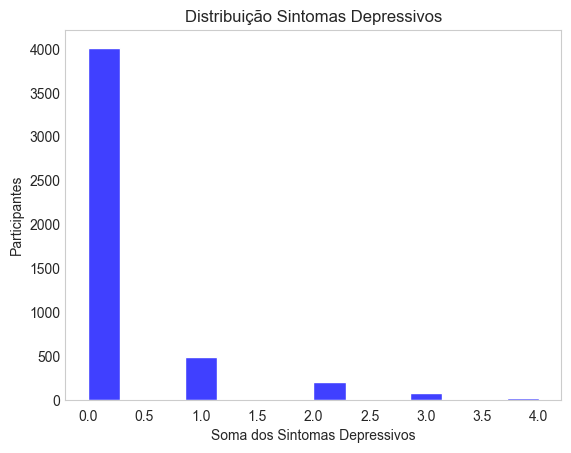

In [7]:
condicoes = [
    (df_completo['PHQ9'].isna()),
    (df_completo['PHQ9'] <= 5),
    (df_completo['PHQ9'] > 5) & (df_completo['PHQ9'] <= 9),
    (df_completo['PHQ9'] > 9) & (df_completo['PHQ9'] <= 14),
    (df_completo['PHQ9'] > 14) & (df_completo['PHQ9'] <= 19),
    (df_completo['PHQ9'] > 19)
]

valores = [np.nan, 0, 1, 2, 3, 4]

df_completo['PHQ_GRP'] = np.select(condicoes, valores)
df_completo['PHQ_GRP'] = df_completo['PHQ_GRP'].astype('Int64')

sns.histplot(data = df_completo['PHQ_GRP'], color = 'blue')
sns.set_style('whitegrid')

plt.title('Distribuição Sintomas Depressivos')
plt.xlabel('Soma dos Sintomas Depressivos')
plt.ylabel('Participantes')
plt.tick_params(axis = 'y', labelsize = 10, length = 0)
plt.tick_params(axis = 'x', labelsize = 10) 
plt.grid(False)

plt.show()

#### Agrupando as categorias com poucos participantes (2, 3 e 4)

In [8]:
df_completo['PHQ_GRP2'] = df_completo['PHQ_GRP'].replace([3, 4], 2)

### ANÁLISE EXPLORATÓRIA UNIVARIADA

Percentis das variáveis numéricas

In [9]:
variaveis_quantitativas = ['RIDAGEYR','INDFMINC','PAG_MINW','HEI2015C1_TOTALVEG','HEI2015C2_GREEN_AND_BEAN','HEI2015C3_TOTALFRUIT','HEI2015C4_WHOLEFRUIT','HEI2015C5_WHOLEGRAIN','HEI2015C6_TOTALDAIRY','HEI2015C7_TOTPROT','HEI2015C8_SEAPLANT_PROT','HEI2015C9_FATTYACID','HEI2015C10_SODIUM','HEI2015C11_REFINEDGRAIN','HEI2015C12_SFAT','HEI2015C13_ADDSUG','HEI2015_TOTAL_SCORE','PHQ9']

df_completo[variaveis_quantitativas].describe(percentiles = [.01, .25, .5,.75, .99]).round(2)

,RIDAGEYR,INDFMINC,PAG_MINW,HEI2015C1_TOTALVEG,HEI2015C2_GREEN_AND_BEAN,HEI2015C3_TOTALFRUIT,HEI2015C4_WHOLEFRUIT,HEI2015C5_WHOLEGRAIN,HEI2015C6_TOTALDAIRY,HEI2015C7_TOTPROT,HEI2015C8_SEAPLANT_PROT,HEI2015C9_FATTYACID,HEI2015C10_SODIUM,HEI2015C11_REFINEDGRAIN,HEI2015C12_SFAT,HEI2015C13_ADDSUG,HEI2015_TOTAL_SCORE,PHQ9
count,5334.00,5174.00,5334.00,5060.00,5060.00,5060.00,5060.00,5060.00,5060.00,5060.00,5060.00,5060.00,5060.00,5060.00,5060.00,5060.00,5060.00,4799.00
mean,45.09,40787.68,471.77,3.20,1.81,2.49,2.36,1.76,3.76,4.43,2.59,4.71,4.76,5.80,6.07,6.22,49.97,2.73
std,20.15,24247.24,780.35,1.47,2.14,1.95,2.17,1.92,1.61,1.01,2.17,3.24,3.42,3.50,3.18,3.33,12.32,3.73
min,18.00,2499.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,16.06,0.00
1%,18.00,2499.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.81,0.00,0.00,0.00,0.00,0.00,0.00,24.68,0.00
25%,27.00,17499.50,35.00,2.06,0.00,0.45,0.00,0.00,2.59,4.17,0.00,2.02,1.59,2.93,3.70,3.72,41.03,0.00
50%,43.00,39999.50,210.00,3.22,0.06,2.32,2.08,1.03,4.94,5.00,2.59,4.43,4.83,6.23,6.41,6.86,49.51,1.00
75%,62.00,69999.50,568.93,4.83,4.50,4.94,5.00,3.41,5.00,5.00,5.00,7.27,7.65,9.25,9.00,9.45,58.17,4.00
99%,85.00,75000.00,3672.06,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,10.00,10.00,10.00,10.00,10.00,79.86,17.00
max,85.00,75000.00,10777.83,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,10.00,10.00,10.00,10.00,10.00,89.53,27.00


Há um problema com a variável **PAG_MINW** que armazena o tempo total (minutos) de atividade física por semana. \
Os percentis acima e o boxplot abaixo evidenciam que os outliers para essa variável ultrapassam a quantidade máxima de minutos que alguém é a capaz de se exercitar em uma semana.

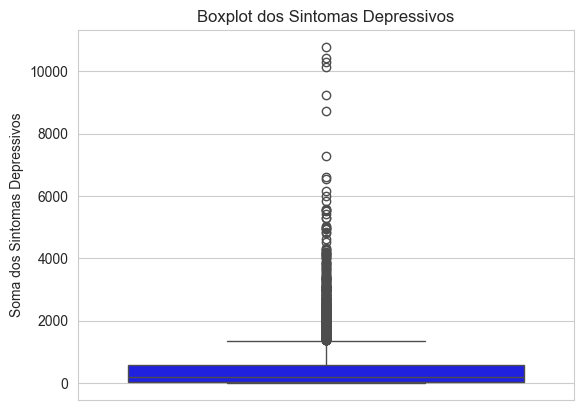

In [10]:
sns.boxplot(y=df_completo['PAG_MINW'], color='blue')  

plt.title('Boxplot dos Sintomas Depressivos')
plt.ylabel('Soma dos Sintomas Depressivos')

plt.show()

Truncando os outliers da variável que informa a quantidade de minutos de exercícios semanais

In [11]:
df_completo['PAG_MINW_TRUNC'] = np.where(df_completo['PAG_MINW'] > 3600, 3600, df_completo['PAG_MINW'])

df_completo[['PAG_MINW', 'PAG_MINW_TRUNC']].describe(percentiles = [.01, .25, .5,.75, .99]).round(2)

,PAG_MINW,PAG_MINW_TRUNC
count,5334.00,5334.00
mean,471.77,454.86
std,780.35,663.05
min,0.00,0.00
1%,0.00,0.00
25%,35.00,35.00
50%,210.00,210.00
75%,568.93,568.93
99%,3672.06,3600.00
max,10777.83,3600.00


Criando uma variável para armazenar o tempo de exercício semanal em horas

In [12]:
df_completo['PAG_HW'] = df_completo['PAG_MINW_TRUNC']/60

Histogramas de algumas variáveis quantitativas

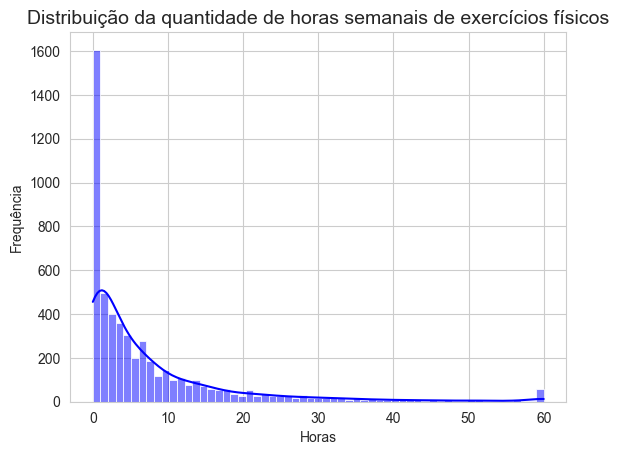

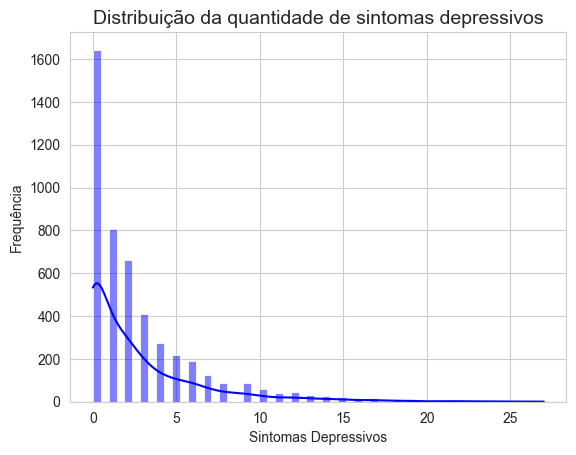

In [19]:
sns.histplot(df_completo['PAG_HW'], kde = True, color = 'Blue')
plt.title('Distribuição da quantidade de horas semanais de exercícios físicos', fontsize = 14)
plt.xlabel('Horas')
plt.ylabel('Frequência')
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=10)
plt.show()


sns.histplot(df_completo['PHQ9'], kde=True, color = 'Blue')
plt.title('Distribuição da quantidade de sintomas depressivos', fontsize = 14)
plt.xlabel('Sintomas Depressivos')
plt.ylabel('Frequência')
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=10)
plt.show()

Gráficos de barras para algumas variáveis categóricas

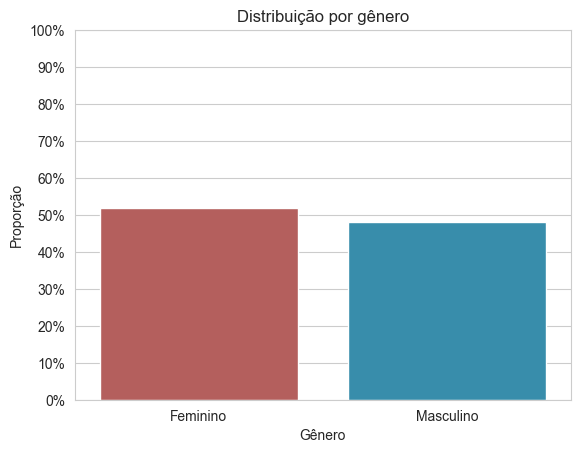

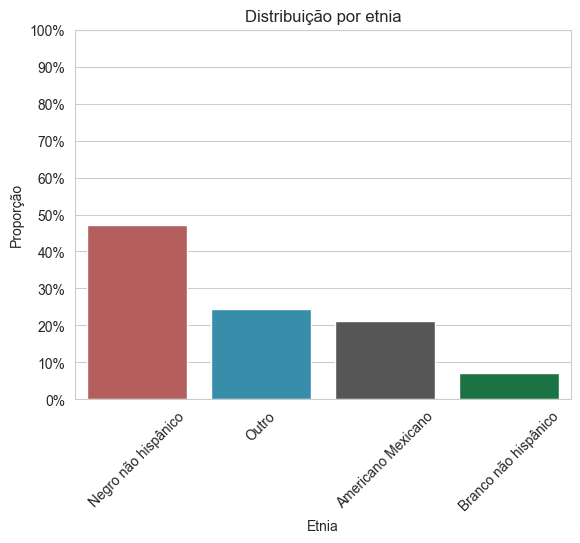

In [14]:
sns.barplot(x = df_completo['RIAGENDR'].map({1: 'Masculino', 2: 'Feminino'}).value_counts(normalize = True).index,
            hue = df_completo['RIAGENDR'].map({1: 'Masculino', 2: 'Feminino'}).value_counts(normalize = True).index, 
            y = df_completo['RIAGENDR'].value_counts(normalize = True).values, palette=[VERMELHO1, AZUL4])

plt.xlabel("Gênero")
plt.ylabel("Proporção")
plt.title("Distribuição por gênero")
plt.yticks([i/10 for i in range(11)], [f"{i*10}%" for i in range(11)])
plt.gca().set_yticklabels([f'{int(x*100)}%' for x in plt.gca().get_yticks()])
plt.ylim(0, 1)

plt.show()


sns.barplot(x = df_completo['RIDRETH1'].map({1: 'Americano Mexicano', 2: 'Branco não hispânico', 3: 'Negro não hispânico', 4: 'Outro'}).value_counts(normalize = True).index,
            hue = df_completo['RIDRETH1'].map({1: 'Americano Mexicano', 2: 'Branco não hispânico', 3: 'Negro não hispânico', 4: 'Outro'}).value_counts(normalize = True).index, 
            y = df_completo['RIDRETH1'].value_counts(normalize = True).values, palette=[VERMELHO1, AZUL4, CINZA3, VERDE1])

plt.xlabel("Etnia")
plt.ylabel("Proporção")
plt.title("Distribuição por etnia")
plt.yticks([i/10 for i in range(11)], [f"{i*10}%" for i in range(11)])
plt.xticks(rotation=45)
plt.gca().set_yticklabels([f'{int(x*100)}%' for x in plt.gca().get_yticks()])
plt.ylim(0, 1)

plt.show()

### ANÁLISE EXPLORATÓRIA BIVARIADA

Investigo visualmente a relação entre exercícios físicos, idade, etnias e gênero com os sintomas depressivos. \
Para isso utilizo boxplot e gráficos de barras. \
Essa análise dará insumos para elaborar hipóteses que serão testadas no final do projeto.

#### Relação entre a quantidade de horas semanais de exercícios físicos e sintomas depressivos

(0.0, 65.0)

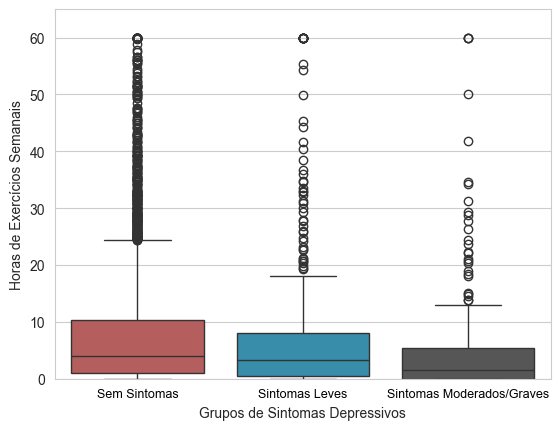

In [39]:
sns.boxplot(x = 'PHQ_GRP2', y = 'PAG_HW', data = df_completo, hue = 'PHQ_GRP2', palette=[VERMELHO1, AZUL4, CINZA3], legend = False)

plt.xlabel('Grupos de Sintomas Depressivos')
plt.ylabel('Horas de Exercícios Semanais')
plt.xticks(ticks=[0, 1, 2], labels=['Sem Sintomas', 'Sintomas Leves', 'Sintomas Moderados/Graves'], fontsize=9, color='black', rotation=0)
plt.ylim(0, 65)

### Relação entre a idade dos participantes e sintomas depressivos

(0.0, 65.0)

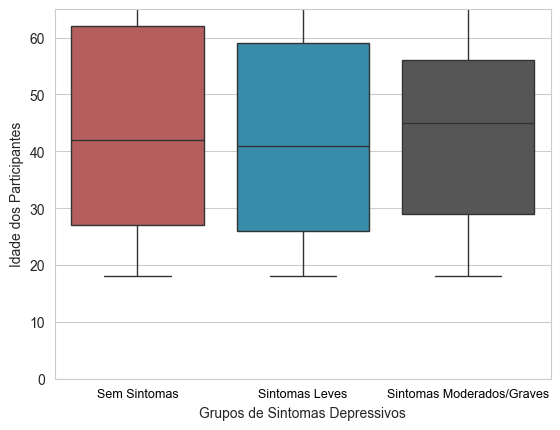

In [47]:
sns.boxplot(x = 'PHQ_GRP2', y = 'RIDAGEYR', data = df_completo, hue = 'PHQ_GRP2', palette=[VERMELHO1, AZUL4, CINZA3], legend = False)

plt.xlabel('Grupos de Sintomas Depressivos')
plt.ylabel('Idade dos Participantes')
plt.xticks(ticks=[0, 1, 2], labels=['Sem Sintomas', 'Sintomas Leves', 'Sintomas Moderados/Graves'], fontsize=9, color='black', rotation=0)
plt.ylim(0, 65) 

### Relação entre as etnias e sintomas depressivos

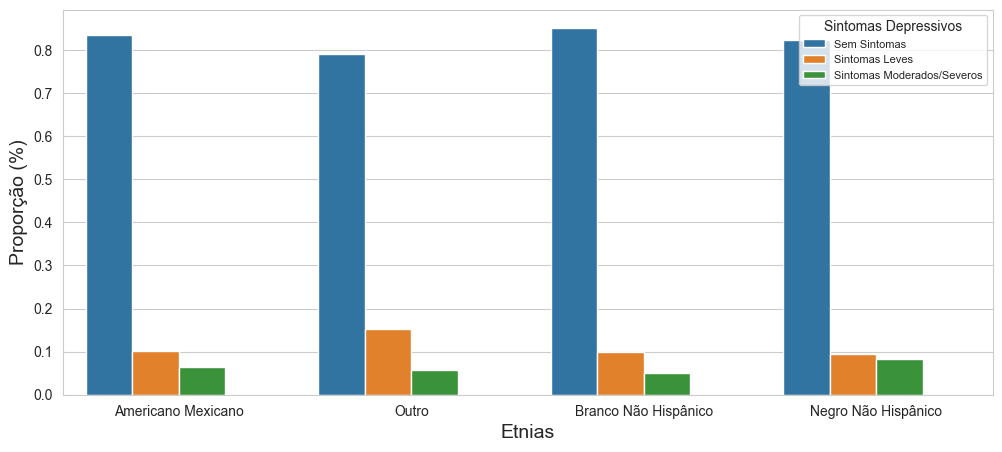

In [16]:
etnia_map = {
    1: 'Americano Mexicano',
    2: 'Outro',
    3: 'Branco Não Hispânico',
    4: 'Negro Não Hispânico'
}

sintomas_map = {
    0:'Sem Sintomas', 
    1:'Sintomas Leves', 
    2:'Sintomas Moderados/Severos'}

df_etnia = df_completo.groupby('RIDRETH1')['PHQ_GRP2']
df_etnia = df_etnia.value_counts(normalize=True, sort=False)
df_etnia = df_etnia.reset_index()
df_etnia.columns = ['RIDRETH1', 'PHQ_GRP2', 'Proporcao']
df_etnia['RIDRETH1'] = df_etnia['RIDRETH1'].map(etnia_map)
df_etnia['PHQ_GRP2'] = df_etnia['PHQ_GRP2'].map(sintomas_map)

fig, ax = plt.subplots(figsize=(12,5))

ax = sns.barplot(data = df_etnia, x = 'RIDRETH1', y = 'Proporcao',  hue = 'PHQ_GRP2', width = 0.6)

ax.set_xlabel('Etnias', fontsize = 14)
ax.set_ylabel('Proporção (%)', fontsize = 14)
ax.legend(title='Sintomas Depressivos', title_fontsize  = 10, fontsize = 8, loc='upper right', bbox_transform=ax.transData)
for bar in ax.patches:
    bar.set_x(bar.get_x() - bar.get_width() / 2)


### Relação entre gênero e sintomas depressivos

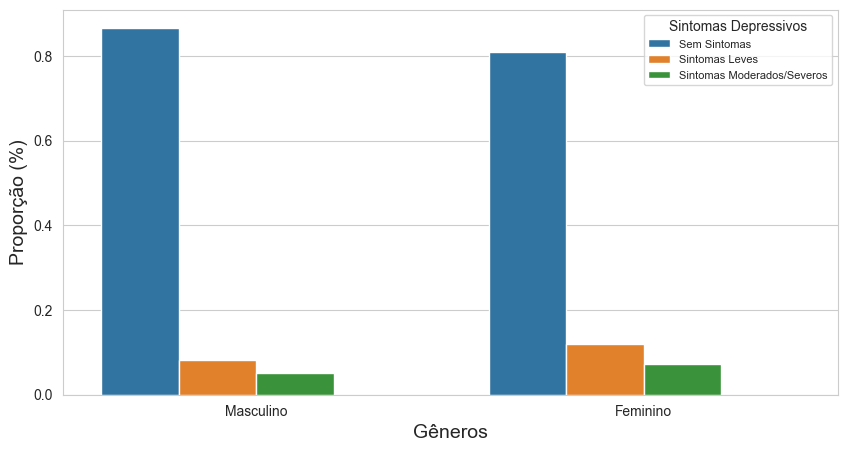

In [17]:
genero_map = {
    1: 'Masculino',
    2: 'Feminino'
}

df_genero = df_completo.groupby('RIAGENDR')['PHQ_GRP2']
df_genero = df_genero.value_counts(normalize=True, sort=False)
df_genero = df_genero.reset_index()
df_genero.columns = ['RIAGENDR', 'PHQ_GRP2', 'Proporcao']
df_genero['RIAGENDR'] = df_genero['RIAGENDR'].map(genero_map)
df_genero['PHQ_GRP2'] = df_genero['PHQ_GRP2'].map(sintomas_map)

fig, ax = plt.subplots(figsize=(10,5))

ax = sns.barplot(data = df_genero, x = 'RIAGENDR', y = 'Proporcao',  hue = 'PHQ_GRP2', width = 0.6)

ax.set_xlabel('Gêneros', fontsize = 14)
ax.set_ylabel('Proporção (%)', fontsize = 14)
ax.legend(title='Sintomas Depressivos', title_fontsize  = 10, fontsize = 8, loc='upper right', bbox_transform=ax.transData)
for bar in ax.patches:
    bar.set_x(bar.get_x() - bar.get_width() / 2)

## **TESTES DE HIPÓTESES**

#### **IDADE E SINTOMAS DEPRESSIVOS**

**Teste ANOVA (F) - Hipóteses** \
H0 - **não há** diferença entre as médias dos grupos (idade) \
H1 - **há** pelo menos uma diferença entre as médias dos grupos

In [18]:
df_aux = df_completo[['PHQ_GRP2', 'RIDAGEYR']].dropna()

stat, p = f_oneway(df_aux[(df_aux['PHQ_GRP2'] == 0)]['RIDAGEYR'],
                   df_aux[(df_aux['PHQ_GRP2'] == 1)]['RIDAGEYR'],
                   df_aux[(df_aux['PHQ_GRP2'] == 2)]['RIDAGEYR'],
                   )

print('stat=%.3f, p=%.3f' % (stat, p))

stat=1.002, p=0.367


Como P-Valor é maior que 0,05 (0.367) não rejeitamos H0 \
Portanto os três grupos de depressão não diferem estatiscamente quanto à média de idade.

#### **EXERCÍCIOS FÍSICOS E SINTOMAS DEPRESSIVOS**

**Teste ANOVA (F) - Hipóteses** \
H0 - os três grupos de depressão **não diferem** quanto à média de tempo gasto com exercício físico. \
H1 - **há pelo menos uma diferença**  na média de tempo gasto com exercício físico entre os três grupos de depressão.

In [19]:
df_aux = df_completo[['PHQ_GRP2', 'PAG_HW']].dropna()

stat, p = f_oneway(df_aux[(df_aux['PHQ_GRP2'] == 0)]['PAG_HW'],
                   df_aux[(df_aux['PHQ_GRP2'] == 1)]['PAG_HW'],
                   df_aux[(df_aux['PHQ_GRP2'] == 2)]['PAG_HW'],
                   )

print('stat=%.3f, p%.3f' % (stat,p))


stat=12.652, p0.000


Como P-Valor é menor que 0,05 (0,000) rejeitamos H0 \
Portanto há pelo menos uma diferença na média de tempo gasto com exercício físico entre os três grupos de depressão.

--------------------------------------

#### **GÊNERO E SINTOMAS DEPRESSIVOS**

**Teste qui-quadrado** \
A proporção de pessoas em cada grupo de depressão varia de acordo com o gênero \
H0 - **não há** associação entre gênero e presença de sintomas depressivos. \
H1 - **há**  associação entre gênero e presença de sintomas depressivos.

In [20]:
crosstab = pd.crosstab(df_completo['RIAGENDR'],
                       df_completo['PHQ_GRP2'])


stat, p, df, expected = chi2_contingency(crosstab)

print('stat = %.3f, p = %.3f' % (stat, p))

stat = 28.811, p = 0.000


Como P-Valor é menor que 0,05 (0,000) rejeitamos H0 \
Portanto há associação entre gênero e presença de sintomas depressivos.

Abaixo é possível verificar numericamente essa diferença (anteriormente essa mesma diferença foi detectada em um gráfico de barras agrupadas)

In [21]:

100 * pd.crosstab(df_completo['RIAGENDR'].map(genero_map),
                  df_completo['PHQ_GRP2'].map(sintomas_map),
                  normalize='index')

PHQ_GRP2,Sem Sintomas,Sintomas Leves,Sintomas Moderados/Severos
RIAGENDR,,,
Feminino,80.860474,11.982308,7.157218
Masculino,86.591696,8.261246,5.147059


# **CONCLUSÃO**

## Comprovada a relação entre sintomas depressivos com gênero e realização de exercícios físicos.